# Clustering
This notebook handles clustering different datapoints and classifying the clusters from most dense to least.
Uses weighted K-Means clustering.

In [106]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from pathlib import Path
from plotting_utility import *

### Grid Points Load (output from scoring.ipynb)
Grid Points are now scored in `scoring.ipynb`.

In [133]:
YYZ_GridPoints = pd.read_csv('../res/grid_points/yyz_grid_points.csv', sep = ',')

### Clustering Parameters

In [134]:
NUM_CLUSTERS = 6
MIN_SCORE_THRESHOLD = 0.5 # minimum score to be considered in the clustering

### Clustering Functions

In [135]:
# Cluster Function, runs k-means clustering and saves the results (cluster) to a new column in the dataframe
def cluster(gridPoints):
    clusteredGridPoints = gridPoints.copy()
    clusteredGridPoints = clusteredGridPoints.loc[clusteredGridPoints['score'] > MIN_SCORE_THRESHOLD]
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(clusteredGridPoints[["lat", "long"]], 0, clusteredGridPoints["score"])
    clusteredGridPoints['cluster'] = kmeans.labels_.tolist()
    return clusteredGridPoints

In [136]:
# Sort Cluster Function, sorts clusters by the average of scores contained in that cluster.
# i.e. we have to sort the clusters so that downtown (the densest area with highest score) is cluster 0, next dense is cluster 1, etc.
def sortClustersByScore(gridPoints):
    clusteredGridPoints = gridPoints.copy()
    clusterScoreSums = []
    for i in range(NUM_CLUSTERS):
        selectedCluster = gridPoints.loc[gridPoints['cluster'] == i]
        clusterScoreSums.append(selectedCluster['score'].mean())
    sortIndiciesDescending = np.argsort(clusterScoreSums)[::-1][:NUM_CLUSTERS].flatten()
    newClusters = {k: v for v, k in enumerate(sortIndiciesDescending)}
    clusteredGridPoints['cluster'] = gridPoints['cluster'].map(newClusters)
    return clusteredGridPoints

### Cluster (YYZ)

In [137]:
# Clustered `Grid Points` is a subset of `Grid Points` with only entries with a score > MIN_SCORE_THRESHOLD, with a cluster column added
YYZ_Clustered_GridPoints = cluster(YYZ_GridPoints)
YYZ_Clustered_GridPoints = sortClustersByScore(YYZ_Clustered_GridPoints)

### Visualization

<Axes3DSubplot:>

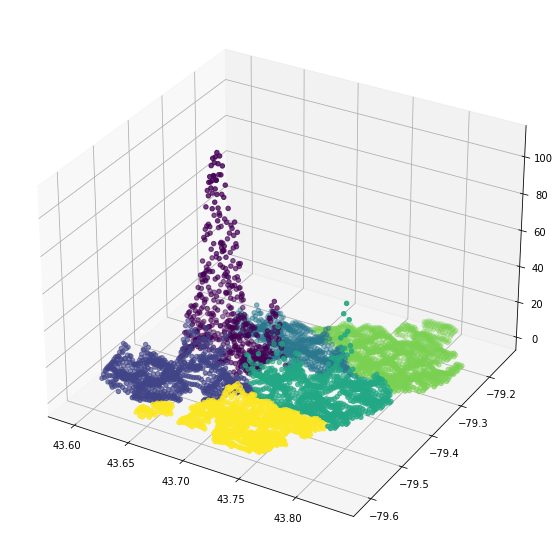

In [138]:
plotGridPoints3D(YYZ_Clustered_GridPoints, YYZ_Clustered_GridPoints['cluster'].astype(float))

<AxesSubplot:>

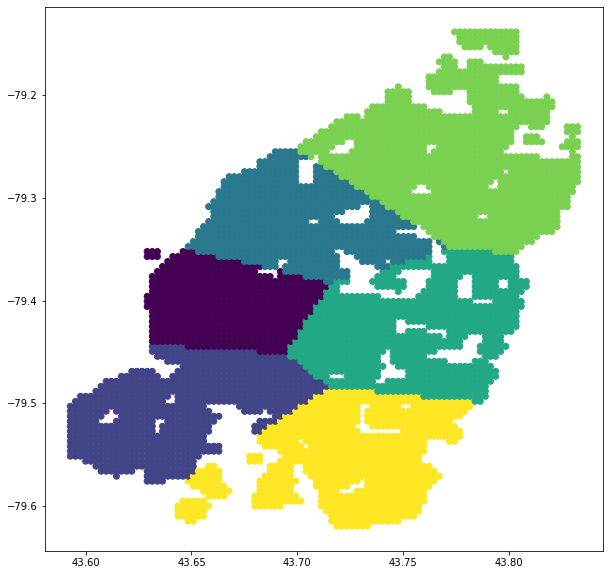

In [139]:
plotGridPoints2D(YYZ_Clustered_GridPoints, YYZ_Clustered_GridPoints["cluster"].astype(float))

### Export

In [140]:
def exportClusteredGridPointsToCsv(gridPoints, name):
    filepath = Path('../res/grid_points/' + name + '.csv')
    filepath.parent.mkdir(parents=True, exist_ok=True)
    gridPoints.to_csv(filepath)

In [141]:
exportClusteredGridPointsToCsv(YYZ_Clustered_GridPoints, 'yyz_clustered_grid_points')